## **Notebook com os Modelos finais**

**Autores:**

- Arthur Brandão do Nascimento

- Caio Ávila Paulo

- Matheus Macedo do Nascimento

## **Introdução**
Este notebook tem por objetivo implementar e comparar diferentes algoritmos de aprendizado de máquina supervisionado de classificação. A partir de características como composição, tamanho e tempo de exposição de diferentes materiais, será prevista sua toxicidade em relação a diferentes tipos de células.

Os algoritmos utilizados serão os de k vizinhos mais próximos (knn), árvore de decisão, floresta aleatória, Support Vector Classifier (SVC) e Regressão Logística. O desempenho de cada um deles será estimado por validação cruzada do tipo k-fold e os hiperparâmetros dos modelos serão otimizados com o Optuna. Além disso, um modelo baseline será estabelecido para fins de comparação.

O Optuna também será usado para testar a normalização dos dados. A métrica a ser otimizada será a f1-macro, adequada ao target categórico binário: a partir dos atributos tanto do material quanto da célula, será atribuído o rótulo "tóxico" ou "não tóxico".

### **Importando as bibliotecas necessárias**

In [353]:
import numpy as np
import pandas as pd
import sklearn as sk
from optuna import create_study
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from seaborn import heatmap
from sklearn.metrics import confusion_matrix
from scipy import stats

### **Importando o dataset**

O dataset escolhido tem, a princípio, 3923 linhas e 17 colunas. 

In [354]:
df = pd.read_csv("../datasets/dataset_nanotoxicologia_combinado.csv")

display(df.shape)
display(df.head())

(3923, 17)

,Material_type,Core_size,Hydro_size,Surface_charge,Surface_area,Formation_enthalpy,Conduction_band,Valence_band,Electronegativity,Assay,Cell_name,Cell_species,Cell_origin,Cell_type,Exposure_time,Exposure_dose,Toxicity
0,Al2O3,39.7,267.0,36.3,64.7,-17.345,-1.51,-9.81,5.67,MTT,HCMEC,Human,Blood,Normal,24.0,0.001,Nontoxic
1,Al2O3,39.7,267.0,36.3,64.7,-17.345,-1.51,-9.81,5.67,MTT,HCMEC,Human,Blood,Normal,24.0,0.010,Nontoxic
2,Al2O3,39.7,267.0,36.3,64.7,-17.345,-1.51,-9.81,5.67,MTT,HCMEC,Human,Blood,Normal,24.0,0.100,Nontoxic
3,Al2O3,39.7,267.0,36.3,64.7,-17.345,-1.51,-9.81,5.67,MTT,HCMEC,Human,Blood,Normal,24.0,1.000,Nontoxic
4,Al2O3,39.7,267.0,36.3,64.7,-17.345,-1.51,-9.81,5.67,MTT,HCMEC,Human,Blood,Normal,24.0,5.000,Nontoxic


### **Definindo as ``FEATURES`` e o ``TARGET``**

As features serão separadas entre aquelas que já são valores numéricos (``FEATURES_NUM``) e aquelas que serão convertidas em valores binários (``FEATURES_DUMMY``).

Variável alvo (**``TARGET``**):
- ``"Toxicity"`` - se a substância, nas dadas condições, é tóxica ou não à célula informada nos atributos.

Features Numéricas (**``FEATURES_NUM``**):

 - ``"Core_size"``, ``"Hydro_size"``, ``"Surface_charge"``, ``"Surface_area"``, ``"Formation_enthalpy"``, ``"Conduction_band"``, ``"Valence_band"``, ``"Electronegativity"`` - características físico-químicas do material analisado.
 
 - ``"Exposure_time"``, ``"Exposure_dose"`` - características da exposição da célula ao material.

Features Categóricas (**``FEATURES_DUMMY``**):

- ``"Material_type"`` - composição do material.

- ``"Assay"``, ``"Cell_name"``, ``"Cell_species"``, ``"Cell_origin"``, ``"Cell_type"`` - características da célula exposta ao material.

In [355]:
FEATURES_NUM = ["Core_size", 
                "Hydro_size", 
                "Surface_charge", 
                "Surface_area", 
                "Formation_enthalpy", 
                "Conduction_band", 
                "Valence_band", 
                "Electronegativity", 
                "Exposure_time", 
                "Exposure_dose"
]

FEATURES_DUMMY = ["Material_type", "Assay", "Cell_name", "Cell_species", "Cell_origin", "Cell_type"]

TARGET = ["Toxicity"]

### **Evitando vazamento de dados pelo ``groupby()``**
Pode ser que vários dados do dataset sejam iguais em todos os atributos, diferindo (ou não) apenas no target. Dessa forma, alguns desses dados poderiam acabar sendo usado na etapa de treino e outros na fase de teste. Isso faria com que a métrica não refletisse o real desempenho do modelo; afinal, ele já "conheceria" alguns dados de teste, o que acarreta uma previsão enviesada.

Para evitar esse tipo de vazamento, *antes* do split de treino e teste, é necessário acabar com essa redundância. Isso é feito agrupando todos os dados duplicados em um só: os atributos continuam os mesmos, mas apenas um valor de target é utilizado, a partir de uma estatística dos dados originais. Como o target é categórico, será usada a moda.

Importante que os dados duplicados não precisam ser cópias idênticas: se todos os atributos forem muito próximos (apesar de não serem iguais), o vazamento de dados ocorrerá da mesma maneira. Por isso, antes de identificar dados repetidos e agrupá-los, arredonda-se o valor de cada atributo em uma casa adequada.

#### **Arredondando**

In [356]:
casa_arredondamento = {
    "Core_size": 0, 
    "Hydro_size": 0, 
    "Surface_charge": 0, 
    "Surface_area": 0, 
    "Formation_enthalpy": 0, 
    "Conduction_band": 0,
    "Valence_band": 0, 
    "Electronegativity": 0, 
    "Exposure_time": 1, 
    "Exposure_dose": 1,
}

df_round = df.round(casa_arredondamento)

df_round.shape

(3923, 17)

Como nós podemos ver pelo código abaixo esse dataset possui alguns dados duplicados

In [357]:
num_duplicados = df_round[FEATURES_NUM + FEATURES_DUMMY].duplicated().sum()
print(f"Número de linhas duplicadas em df_round: {num_duplicados}")

Número de linhas duplicadas em df_round: 43


#### **Agrupando**

O [``agg()``](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html) é um método do pandas usado para aplicar uma ou mais operações de agregação em grupos de dados. Como o target (``"Toxicity"``) é categórico, usaremos a moda para decidir o rótulo daquele grupo.

In [358]:
def calcular_moda(serie):
    """Calcula a moda de uma série"""
    moda = serie.mode()
    return moda[0]

In [359]:
df_grouped = df_round.groupby(FEATURES_NUM + FEATURES_DUMMY, sort=False)

agg_dict = {
    **{col: "mean" for col in FEATURES_NUM},
    **{col: calcular_moda for col in FEATURES_DUMMY},
    "Toxicity": calcular_moda
}

df_grouped = df_grouped.agg(agg_dict)
df_grouped = df_grouped.reset_index(drop=True)

print(f"O shape (linhas x colunas) do df_round é: {df_round.shape}")
print(f"O shape (linhas x colunas) do df_tratado é: {df_grouped.shape}")

O shape (linhas x colunas) do df_round é: (3923, 17)
O shape (linhas x colunas) do df_tratado é: (3880, 17)


In [360]:
num_duplicados = df_grouped[FEATURES_NUM + FEATURES_DUMMY].duplicated().sum()
print(f"Número de linhas duplicadas em df_grouped: {num_duplicados}")

Número de linhas duplicadas em df_grouped: 0


Como podemos ver não há mais valores duplicados

### **Fazendo a codificação One-Hot**
Os algoritmos de aprendizado de máquina utilizados exigem que todos os atributos sejam numéricos. Dessa forma, é necessário transformar os dados qualitativos adequadamente.  O codificador One-Hot transforma uma coluna de dados categóricos em várias colunas, cada qual representando um dos rótulos possíveis; se o dado originalmente tinha aquele rótulo, atribui-se o valor 1, caso contrário preenche-se com 0. Isso será feito com todos os ``"FEATURES_DUMMY"``.

In [361]:
encoder = OneHotEncoder(sparse_output=False, dtype=np.int32)
dummy_encoded = encoder.fit_transform(df_grouped[FEATURES_DUMMY])

dummy_columns = encoder.get_feature_names_out(FEATURES_DUMMY)
df_dummy = pd.DataFrame(dummy_encoded, columns=dummy_columns, index=df_grouped.index)

df_dummy = pd.concat([df_grouped[FEATURES_NUM + TARGET], df_dummy], axis=1)
FEATURES_FINAL = FEATURES_NUM + list(dummy_columns)

display(df_dummy.shape)
display(df_dummy.head(5))

(3880, 203)

,Core_size,Hydro_size,Surface_charge,Surface_area,Formation_enthalpy,Conduction_band,Valence_band,Electronegativity,Exposure_time,Exposure_dose,...,Cell_origin_Pancreas,Cell_origin_Plant cell,Cell_origin_Prostate,Cell_origin_Skin,Cell_origin_Stomach,Cell_origin_Tetis,Cell_origin_Tongue,Cell_origin_Umbilical vein,Cell_type_Cancer,Cell_type_Normal
0,40.0,267.0,36.0,65.0,-17.0,-2.0,-10.0,6.0,24.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,40.0,267.0,36.0,65.0,-17.0,-2.0,-10.0,6.0,24.0,0.1,...,0,0,0,0,0,0,0,0,0,1
2,40.0,267.0,36.0,65.0,-17.0,-2.0,-10.0,6.0,24.0,1.0,...,0,0,0,0,0,0,0,0,0,1
3,40.0,267.0,36.0,65.0,-17.0,-2.0,-10.0,6.0,24.0,5.0,...,0,0,0,0,0,0,0,0,0,1
4,40.0,267.0,36.0,65.0,-17.0,-2.0,-10.0,6.0,24.0,10.0,...,0,0,0,0,0,0,0,0,0,1


### **Definindo os dados de treino e de teste**
Com o dataframe devidamente tratado, pode ser feita a divisão dos dados em teste e treino. No caso será utilizado o ``stratify`` pois há um certo desbalanço no dataset, havendo mais dados sobre nanopartículas não tóxicas do que nanopartículas tóxicas, o ``"stratify"`` mantém a proporção das classes em ambos os conjuntos.

In [362]:
TAMANHO_TESTE = 0.25
SEED = 404

valores_target = df_dummy[TARGET].values.ravel()

df_treino, df_teste = train_test_split(df_dummy, test_size=TAMANHO_TESTE, random_state=SEED, stratify=valores_target)

X_teste = df_teste.reindex(FEATURES_FINAL, axis=1)
y_teste = df_teste.reindex(TARGET, axis=1).values.ravel()

X_treino = df_treino.reindex(FEATURES_FINAL, axis=1)
y_treino = df_treino.reindex(TARGET, axis=1).values.ravel()

### **Criando os modelos e espaços de busca**

Serão criados os seguintes modelos para comparação:

- Baseline (DummyClassifier)
- k-Nearest Neighbors classifier (KNN)
- Árvore de Decisão
- Floresta Aleatória
- Regressão Logística
- Support Vector Classifier


#### **Baseline**

O baseline estabelece uma referência mínima de desempenho, onde qualquer modelo útil deve superar essa referência.

No caso, foi utilizado o ``DummyClassifier(strategy='most_frequent')``, que prevê sempre a moda dos valores de y.

In [363]:
modelo_baseline = DummyClassifier(strategy="most_frequent")

modelo_baseline.fit(X_treino, y_treino)
y_prev_estimativa_baseline = modelo_baseline.predict(X_teste)

f1_macro_estimativa_dummy = f1_score(y_teste, y_prev_estimativa_baseline, pos_label="Nontoxic")
f1_macro_estimativa_dummy

0.868144690781797

#### **Implementação dos Modelos com o Optuna**
O Optuna é um framework de otimização de hiperparâmetros. Ele automatiza o processo de enontrar o conjunto ótimo de hiperparâmetros para um dado modelo, almejando minimizar ou maximizar uma função objetiva específica.

No Optuna, os ``Trials`` são as tentativas com diferentes combinações de hiperparâmetros e o ``Study`` é o conjunto de trials para um determinado objetivo.

Nesse contexto, a função ``cria_instancia_modelo`` serve para criar uma instância do modelo escolhido, recebendo um trial.
Para definir o espaço do dicionário dos parâmetros é usado o ``trial.suggest_*()``.

Além disso, foi utilizada a decisão de normalização dos dados como um hiperparâmetro adicional. Para isso foi criado um curto **pipeline** com o ``make_pipeline()``

#### **Instância K-NN**

Baseado no princípio de que exemplos similares tendem a pertencer à mesma classe. Para classificar uma nova amostra, o algoritmo calcula as distâncias entre essa amostra e os pontos do conjunto de treinamento, identifica os K vizinhos mais próximos e realiza uma votação majoritária entre suas classes.

Hiperparâmetros Otimizados:

- **``n_neighbors``**: número de vizinhos

- **``weights``**: uniform, sem pesos, ou distance, em que vizinhos mais próximos tem mais peso

- **``p``**: tipo de distância, 1=Manhattan, 2=Euclidiana

In [364]:
def cria_instancia_knn(trial):
    """Cria uma instância de um modelo KNN."""

    parametros = {
        "n_neighbors": trial.suggest_int("num_vizinhos", 1, 200, log=True),
        "weights": trial.suggest_categorical("pesos", ["uniform", "distance"]),
        "p": trial.suggest_int("tipo_distancia", 1, 2),
        "n_jobs": -1,
    }

    normalizar = trial.suggest_categorical("normalizar", [True, False])

    if normalizar:
        tipo_normalizacao = trial.suggest_categorical("tipo_norm", ["Standard", "MinMax", "MaxAbs"])

        if tipo_normalizacao == "Standard":
            normalizador = StandardScaler()
        elif tipo_normalizacao == "MinMax":
            normalizador = MinMaxScaler()
        elif tipo_normalizacao == "MaxAbs":
            normalizador = MaxAbsScaler()
            
        modelo_knn = make_pipeline(
            normalizador,
            KNeighborsClassifier(**parametros)
        )
    
    else:
        modelo_knn = KNeighborsClassifier(**parametros)

    return modelo_knn

#### **Instância Árvore de Decisão**

O algoritmo da árvore de decisão constrói uma estrutura similar a um fluxograma, onde cada nó interno representa uma decisão baseada em uma feature específica, cada ramo representa o resultado dessa decisão e cada nó folha representa a classe predita. O processo de construção da árvore segue uma estratégia que visa a máxima separação dos nós resultantes em cada divisão, utilizando critérios como entropia ou índice Gini para medir a homogeneidade das classes. A principal vantagem das árvores de decisão em relação às florestas aleatórias reside em sua alta interpretabilidade.

Hiperparâmetros Otimizados:

- **``max_depth``**: Profundidade máxima da árvore

- **``criterion``**: A função usada para medir a qualidade de um _split_ em cada nó

- **``min_samples_split``**: Número mínimo de amostras necessárias para dividir um nó

- **``min_samples_leaf``**:  Número mínimo de amostras em um nó folha

- **``max_features``**: Limita o número de features que o algorítimo utiliza em cada divisão para determinar a melhor features de divisão.


In [365]:
def cria_instancia_dtree(trial):
    """Cria a instância de um modelo de árvore de decisão"""

    parametros = {
        "max_depth": trial.suggest_int("profundidade", 2, 600, log=True),
        "criterion": trial.suggest_categorical("critério", ['entropy', 'log_loss', 'gini']),
        "min_samples_split": trial.suggest_int("min_exemplos_split", 2, 200, log=True),
        "min_samples_leaf": trial.suggest_int("min_exemplos_folha", 1, 100, log=True),
        "max_features": trial.suggest_float("num_max_features", 0, 1),
        "random_state": SEED,
    }

    normalizar = trial.suggest_categorical("normalizar", [True, False])

    if normalizar:
        tipo_normalizacao = trial.suggest_categorical("tipo_norm", ["Standard", "MinMax", "MaxAbs"])

        if tipo_normalizacao == "Standard":
            normalizador = StandardScaler()
        elif tipo_normalizacao == "MinMax":
            normalizador = MinMaxScaler()
        elif tipo_normalizacao == "MaxAbs":
            normalizador = MaxAbsScaler()
            
        modelo_dtree = make_pipeline(
            normalizador,
            DecisionTreeClassifier(**parametros)
        )
    
    else:
        modelo_dtree = DecisionTreeClassifier(**parametros)

    return modelo_dtree

#### **Instância Floresta Aleatória (RF)**

A floresta aleatória é uma técnica que combina o princípio de comitês com aleatorização adicional de features para criar múltiplas árvores de decisão diversas. Cada árvore na floresta é treinada em uma amostra bootstrap, amostragem aleatória com reposição, do conjunto de dados original e, em cada divisão da árvore, apenas um subconjunto aleatório de features é considerado para divisão. Essa aleatorização garante que as árvores individuais sejam diferentes umas das outras, reduzindo a correlação entre seus erros. Durante a predição, todas as árvores votam na classe final, com a maioria decidindo o resultado. Essa abordagem coletiva resulta em um modelo que geralmente supera árvores individuais, embora não seja interpretável e tenha um custo computacional maior.

Hiperparâmetros Otimizados:

- **``n_estimators``**: Número de árvores utilizadas no modelo

- **``criterion``**: A função usada para medir a qualidade de um _split_ em cada nó

- **``max_depth``**: Controla profundidade maxíma individual das árvores

- **``min_samples_split``**: Número mínimo de amostras necessárias para dividir um nó

- **``min_samples_leaf``**: Número mínimo de amostras em um nó folha

- **``max_features``**: Limita o número de features que o algorítimo utiliza em cada divisão para determinar a melhor features de divisão.

In [366]:
def cria_instancia_rf(trial):
    """Cria a instância de um modelo de floresta aleatória."""

    parametros = {
        "n_estimators": trial.suggest_int("num_arvores", 2, 1000, log=True),
        "criterion": trial.suggest_categorical("critério", ["log_loss", "gini", "entropy"]),
        "max_depth": trial.suggest_int("max_depth", 1, 600, log=True),
        "min_samples_split": trial.suggest_int("min_exemplos_split", 2, 200),
        "min_samples_leaf": trial.suggest_int("min_exemplos_folha", 1, 100),
        "max_features": trial.suggest_float("num_max_atributos", 0, 1),
        "n_jobs": -1,
        "bootstrap": True,
        "random_state": SEED,
    }

    normalizar = trial.suggest_categorical("normalizar", [True, False])
    if normalizar:
        tipo_normalizacao = trial.suggest_categorical("tipo_norm", ["Standard", "MinMax", "MaxAbs"])

        if tipo_normalizacao == "Standard":
            normalizador = StandardScaler()
        elif tipo_normalizacao == "MinMax":
            normalizador = MinMaxScaler()
        elif tipo_normalizacao == "MaxAbs":
            normalizador = MaxAbsScaler()

        modelo_rf = make_pipeline(
            normalizador,
            RandomForestClassifier(**parametros)
        )
    
    else:
        modelo_rf = RandomForestClassifier(**parametros)

    return modelo_rf

#### **Instância Regressão Logística (LR)**

A regressão logística é um algoritmo de classificação que modela a probabilidade de uma amostra pertencer a uma classe específica usando a função logística (sigmoide). O modelo assume uma relação linear entre as features e o logarítimo da chance da probabilidade da classe positiva. A inclusão de termos de regularização (L1, L2 ou Elastic Net) ajuda a prevenir overfitting e a lidar com multicolinearidade entre as features.

Hiperparâmetros Otimizados:

- **``penalty``**: É o tipo de regularização utilizada 

- **``C``**: Controla a intesidade da regularização

- **``l1_ratio ``**: Balanceamento entre penalidades L1 e L2, utilizada apenas pelo elasticnet

Há também um parâmetro chamado `class_weight` que nos auxilia a lidar com variáveis ditas "não-balanceadas". Basicamente, esse hiperparâmetro decide se o modelo vai se importar mais com a acurácia no geral ou na identificação correta de _outliers_. Ele ajusta a influência de cada uma dos atributos durante o treinamento, forçando o modelo a prestar mais atenção nos valores menos frequentes em colunas de acordo com o peso.

In [367]:
def cria_instancia_lr(trial):
    """Cria a instância de um modelo de Regressão Logística."""

    parametros = {
        "penalty": trial.suggest_categorical("penalidade", ["l1", "l2", "elasticnet"]),
        "C": trial.suggest_float("C", 1e-3, 1e3, log=True),
        "class_weight": "balanced", 
        "solver": "saga",
        "max_iter": 10000,
        "n_jobs": -1,
        "random_state": SEED,
    }

    if parametros["penalty"] == "elasticnet":
        parametros["l1_ratio"] = trial.suggest_float("l1_ratio", 0.1, 0.9)
    
    normalizar = trial.suggest_categorical("normalizar", [True, False])

    if normalizar:
        tipo_normalizacao = trial.suggest_categorical("tipo_norm", ["Standard", "MinMax", "MaxAbs"])

        if tipo_normalizacao == "Standard":
            normalizador = StandardScaler()
        elif tipo_normalizacao == "MinMax":
            normalizador = MinMaxScaler()
        elif tipo_normalizacao == "MaxAbs":
            normalizador = MaxAbsScaler()
            
        modelo_lr = make_pipeline(
            normalizador,
            LogisticRegression(**parametros)
        )
    
    else:
        modelo_lr = LogisticRegression(**parametros)

    return modelo_lr

#### **Instância Support Vector Classifier (SVC)**

O SVC é um algoritimo que tem uma fundamentação matemática centrada em encontrar hiperplanos que maximizem as chamadas "margens" (distância entre o hiperplano de decisão e os exemplos mais próximos de cada classe) entre classes. Os hiperparâmetros controlam coisas como: o quão estrita a separação de pontos deve ser (hiperparâmetro c), que tipo de barreira de decisão usar (kernel) e o quão complexa essa barreira pode ser (gamma, degree). É vital otimizá-los para poder obter um modelo funcional que não superestime ou subestime a contribuição de uma variável.

Hiperparâmetros Otimizados:

- **``C``**: é um parâmetro regularizador, que controla a troca entre tamanho da margem e erro de classificação, um C pequeno tem melhor generalização, já um C maior tem um risco de _overfitting_.

- **``kernel``**: controla o formato da fronteira de decisão.

- **``gamma``**: é o coeficiente do kernel, que influencia o alcance de cada ponto individual no treinamento.

- **``degree``**: é grau polinomial, caso o kernel seja polinomial, controla a complexidade do polinômio.

- **``coef0``**: é o termo independente, que controla o deslocamento em kernels polinomiais ou sigmóides

Além disso, há novamente o parâmetro `class_weight`.

In [368]:
def cria_instancia_svc(trial):
    """Cria a instância de um modelo de SVC"""
    
    parametros = {
        "C": trial.suggest_float("C", 0.01, 1000.0, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "rbf","poly", "sigmoid"]),
        "class_weight": "balanced",
        "random_state": SEED,
        "max_iter": 600000,
    }

    if parametros["kernel"] in ["rbf", "poly", "sigmoid"]:
        entrada_gamma = trial.suggest_categorical("entrada_gamma", ["scale", "auto", "float"])

        if entrada_gamma == "scale":
            parametros["gamma"] = "scale"
        elif entrada_gamma == "auto":
            parametros["gamma"] = "auto"
        elif entrada_gamma == "float":
            parametros["gamma"] = trial.suggest_float("gamma", 1e-5, 1e2, log=True)
    
    if parametros["kernel"] == "poly":
        parametros["degree"] = trial.suggest_int("degree", 1, 4)

    normalizar = trial.suggest_categorical("normalizar", [True, False])

    if normalizar:
        tipo_normalizacao = trial.suggest_categorical("tipo_norm", ["Standard", "MinMax", "MaxAbs"])

        if tipo_normalizacao == "Standard":
            normalizador = StandardScaler()
        elif tipo_normalizacao == "MinMax":
            normalizador = MinMaxScaler()
        elif tipo_normalizacao == "MaxAbs":
            normalizador = MaxAbsScaler()
            
        modelo_svc = make_pipeline(
            normalizador,
            SVC(**parametros)
        )
    
    else:
        modelo_svc = SVC(**parametros)

    return modelo_svc

### **Função Objetivo**

A seguir foi criada a função objetivo que é a função que irá computar a métrica de interesse. Neste caso, a métrica de interesse é a f1-macro, obtida por validação cruzada.

A métrica ``f1-macro`` funciona da seguinte forma:

- Precisão = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Positivos) 
    - De todas as previsões positivas, quantas eram realmente positivas

- Recall = Verdadeiros Positivos / (Verdadeiros Positivos + Falsos Negativos) 
    - De todos os casos realmente positivos, quantos foram identificados corretamente

A métrica calcula a média harmônica entre a precisão e o recall:

- **F1 = 2 × (Precision × Recall) / (Precision + Recall)**

Nela, cada rótulo do target tem o mesmo peso, independente de quantos exemplos tenha, o que é útil para o nosso caso.

In [369]:
def funcao_objetivo(trial, X, y, num_folds, modelo="knn"):
    """Função objetivo do optuna"""

    if modelo == "knn":
        modelo = cria_instancia_knn(trial)
    elif modelo == "dtree":
        modelo = cria_instancia_dtree(trial)
    elif modelo == "rf":
        modelo = cria_instancia_rf(trial)
    elif modelo == "lr":
        modelo = cria_instancia_lr(trial)
    elif modelo == "svc":
        modelo = cria_instancia_svc(trial)
    
    metricas = cross_val_score(
        modelo, 
        X, 
        y, 
        scoring="f1_macro",
        cv=num_folds,
        )
    
    return metricas.mean()


### **Otimizando os Hiperparâmetros**

A seguir foram criados os estudos (conjunto de trials) usando o ``create_study()``, cujo argumento ``direction='maximize'`` tem como objetivo maximizar a f1-macro. Foi o utilizado o ``storage`` para armazenar o progreso da busca e o  ``load_if_exists`` para que seja possível continuar a busca de onde ela parou.

In [370]:
NOME_DO_ESTUDO_KNN = "knn_nanotoxiclogia_optuna"
NOME_DO_ESTUDO_DTREE = "dtree_nanotoxiclogia_optuna"
NOME_DO_ESTUDO_SVC = "svc_nanotoxiclogia_optuna"
NOME_DO_ESTUDO_RF = "rf_nanotoxiclogia_optuna"
NOME_DO_ESTUDO_LR = "lr_nanotoxiclogia_optuna"

objeto_de_estudo_knn = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO_KNN,
    storage=f"sqlite:///../resultados_optuna/{NOME_DO_ESTUDO_KNN}.db",
    load_if_exists=True,
)

objeto_de_estudo_dtree = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO_DTREE,
    storage=f"sqlite:///../resultados_optuna/{NOME_DO_ESTUDO_DTREE}.db",
    load_if_exists=True,
)

objeto_de_estudo_svc = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO_SVC,
    storage=f"sqlite:///../resultados_optuna/{NOME_DO_ESTUDO_SVC}.db",
    load_if_exists=True,
)

objeto_de_estudo_rf = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO_RF,
    storage=f"sqlite:///../resultados_optuna/{NOME_DO_ESTUDO_RF}.db",
    load_if_exists=True,
)

objeto_de_estudo_lr = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO_LR,
    storage=f"sqlite:///../resultados_optuna/{NOME_DO_ESTUDO_LR}.db",
    load_if_exists=True,
)

[I 2025-11-03 21:31:45,495] Using an existing study with name 'knn_nanotoxiclogia_optuna' instead of creating a new one.
[I 2025-11-03 21:31:45,608] Using an existing study with name 'dtree_nanotoxiclogia_optuna' instead of creating a new one.
[I 2025-11-03 21:31:45,748] Using an existing study with name 'svc_nanotoxiclogia_optuna' instead of creating a new one.
[I 2025-11-03 21:31:45,844] Using an existing study with name 'rf_nanotoxiclogia_optuna' instead of creating a new one.
[I 2025-11-03 21:31:45,978] Using an existing study with name 'lr_nanotoxiclogia_optuna' instead of creating a new one.


Para realmente rodar o otimizador precisamos de uma função objetivo que tenha apenas um argumento, o `trial`. Para isso vamos definir a `funcao_objetivo_parcial`.

Serão usados ``modelo='modelo'`` para cada modelo e um número de fols na validação cruzada igual a 10.

In [371]:
NUM_FOLDS = 10

def funcao_objetivo_parcial_knn(trial):
    return funcao_objetivo(trial, X_treino, y_treino, NUM_FOLDS, modelo="knn")

def funcao_objetivo_parcial_dtree(trial):
    return funcao_objetivo(trial, X_treino, y_treino, NUM_FOLDS, modelo="dtree")

def funcao_objetivo_parcial_rf(trial):
    return funcao_objetivo(trial, X_treino, y_treino, NUM_FOLDS, modelo="rf")

def funcao_objetivo_parcial_svc(trial):
    return funcao_objetivo(trial, X_treino, y_treino, NUM_FOLDS, modelo="svc")

def funcao_objetivo_parcial_lr(trial):
    return funcao_objetivo(trial, X_treino, y_treino, NUM_FOLDS, modelo="lr")


Agora podemos definiro o número de novos trials e rodar cada otimização de modelo separadamente.

In [ ]:
NUM_TENTATIVAS = 150
objeto_de_estudo_knn.optimize(funcao_objetivo_parcial_knn, n_trials=NUM_TENTATIVAS)

[I 2025-11-03 21:31:48,316] Trial 1032 finished with value: 0.821918730539496 and parameters: {'num_vizinhos': 1, 'pesos': 'uniform', 'tipo_distancia': 1, 'normalizar': False}. Best is trial 148 with value: 0.8402578592356329.


In [ ]:
NUM_TENTATIVAS = 150
objeto_de_estudo_dtree.optimize(funcao_objetivo_parcial_dtree, n_trials=NUM_TENTATIVAS)

[I 2025-11-03 21:31:49,949] Trial 1029 finished with value: 0.8494194563987334 and parameters: {'profundidade': 595, 'critério': 'entropy', 'min_exemplos_split': 20, 'min_exemplos_folha': 1, 'num_max_features': 0.5895145600330386, 'normalizar': False}. Best is trial 781 with value: 0.8961577595288454.


In [ ]:
NUM_TENTATIVAS = 150
objeto_de_estudo_svc.optimize(funcao_objetivo_parcial_svc, n_trials=NUM_TENTATIVAS)

[I 2025-11-03 21:32:04,221] Trial 1430 finished with value: 0.8297338650795252 and parameters: {'C': 701.1516135537896, 'kernel': 'rbf', 'entrada_gamma': 'float', 'gamma': 1.378800523925654e-05, 'normalizar': False}. Best is trial 1059 with value: 0.8508233453451532.


In [375]:
NUM_TENTATIVAS = 150
objeto_de_estudo_rf.optimize(funcao_objetivo_parcial_rf, n_trials=NUM_TENTATIVAS)

[I 2025-11-03 21:32:25,672] Trial 1436 finished with value: 0.9027717076953079 and parameters: {'num_arvores': 438, 'critério': 'entropy', 'max_depth': 445, 'min_exemplos_split': 10, 'min_exemplos_folha': 1, 'num_max_atributos': 0.730675353192489, 'normalizar': False}. Best is trial 898 with value: 0.9112519576543396.


In [ ]:
NUM_TENTATIVAS = 150
objeto_de_estudo_lr.optimize(funcao_objetivo_parcial_lr, n_trials=NUM_TENTATIVAS)

### **Vizualizando os Resultados**

Agora podemos analizar o foi obtido com cada modelo e a partir disso definir qual deles teve o melhor estimativa de resultado.

#### **Resultado Dummy (baseline):**

In [379]:
print(f"A estimativa do f1-macro para o Dummy foi: {f1_macro_estimativa_dummy}")

A estimativa do f1-macro para o Dummy foi: 0.868144690781797


#### **Resultado K-NN:**

In [380]:
melhor_trial_knn = objeto_de_estudo_knn.best_trial

print(f"Número do melhor trial K-NN: {melhor_trial_knn.number}")
print(f"Parâmetros do melhor trial : {melhor_trial_knn.params}")
print(f"A melhor estimativa do f1-macro para o K-NN foi: {objeto_de_estudo_knn.best_value}")

Número do melhor trial K-NN: 148
Parâmetros do melhor trial : {'num_vizinhos': 1, 'pesos': 'uniform', 'tipo_distancia': 1, 'normalizar': True, 'tipo_norm': 'MaxAbs'}
A melhor estimativa do f1-macro para o K-NN foi: 0.8402578592356329


#### **Resultado Árvore de Decisão:**

In [381]:
melhor_trial_dtree = objeto_de_estudo_dtree.best_trial

print(f"Número do melhor trial da Árvore de Decisão: {melhor_trial_dtree.number}")
print(f"Parâmetros do melhor trial da Árvore de Decisão: {melhor_trial_dtree.params}")
print(f"A melhor estimativa do f1-macro para a Árvore de Decisão foi: {objeto_de_estudo_dtree.best_value}")

Número do melhor trial da Árvore de Decisão: 781
Parâmetros do melhor trial da Árvore de Decisão: {'profundidade': 29, 'critério': 'entropy', 'min_exemplos_split': 2, 'min_exemplos_folha': 1, 'num_max_features': 0.4819347463126588, 'normalizar': True, 'tipo_norm': 'MinMax'}
A melhor estimativa do f1-macro para a Árvore de Decisão foi: 0.8961577595288454


#### **Resultado SVC:**

In [382]:
melhor_trial_svc = objeto_de_estudo_svc.best_trial

print(f"Número do melhor trial do SVC: {melhor_trial_svc.number}")
print(f"Parâmetros do melhor trial do SVC: {melhor_trial_svc.params}")
print(f"A melhor estimativa do f1-macro para o SVC foi: {objeto_de_estudo_svc.best_value}")

Número do melhor trial do SVC: 1059
Parâmetros do melhor trial do SVC: {'C': 992.1950516156445, 'kernel': 'rbf', 'entrada_gamma': 'float', 'gamma': 3.25151263422672e-05, 'normalizar': False}
A melhor estimativa do f1-macro para o SVC foi: 0.8508233453451532


#### **Resultado Floresta Aleatória:**

In [383]:
melhor_trial_rf = objeto_de_estudo_rf.best_trial

print(f"Número do melhor trial da Floresta Aleatória: {melhor_trial_rf.number}")
print(f"Parâmetros do melhor trial da Floresta Aleatória: {melhor_trial_rf.params}")
print(f"A melhor estimativa do f1-macro para a Floresta Aletória foi: {objeto_de_estudo_rf.best_value}")

Número do melhor trial da Floresta Aleatória: 898
Parâmetros do melhor trial da Floresta Aleatória: {'num_arvores': 403, 'critério': 'entropy', 'max_depth': 301, 'min_exemplos_split': 6, 'min_exemplos_folha': 1, 'num_max_atributos': 0.5282007906767744, 'normalizar': False}
A melhor estimativa do f1-macro para a Floresta Aletória foi: 0.9112519576543396


#### **Resultado Regressão Logística:**

In [384]:
melhor_trial_lr = objeto_de_estudo_lr.best_trial

print(f"Número do melhor trial da Regressão Logística: {melhor_trial_lr.number}")
print(f"Parâmetros do melhor trial da Regressão Logística: {melhor_trial_lr.params}")
print(f"A melhor estimativa do f1-macro para a Regressão Logística foi: {objeto_de_estudo_lr.best_value}")

Número do melhor trial da Regressão Logística: 12
Parâmetros do melhor trial da Regressão Logística: {'penalidade': 'l1', 'C': 137.97053160889004, 'normalizar': True, 'tipo_norm': 'MinMax'}
A melhor estimativa do f1-macro para a Regressão Logística foi: 0.7383435156883571


### **Resultados da Otimização**

Com os modelos otimizados com o Optuna, pôde-se encontrar combinações de hiperparâmetros que maximizassem a estimativa do F1-score macro.

| Modelo               |  Expectiva F1-Macro |   Melhor Trial |
|----------------------|------------|----------------|
| Baseline             |     0.8681 |              - |
| K-NN                 |     0.8402 |            148 |
| Árvore de Decisão    |     0.8961 |            781 |
| SVC                  |     0.8508 |           1059 |
| Floresta Aleatória   |     0.9112 |            898 |
| Regressão Logística  |     0.7383 |             12 |

A principio foi possível observar que:

Todos os modelos superaram significativamente o baseline, exceto a regressão logística, mostrando que as features e modelos utilizados possuem um valor preditivo. Além disso, modelos como Floresta Aleatória e a Árvore de Decisão tiveram um melhor resultado.

**OBS:** O termo expectativa foi utilizado pois o valor obtito de desempenho foi gerado pela validação cruzada nos dados de treino e 

### **Avaliando os modelos nos dados de treino**

A validação cruzada fornece uma estimativa do desempenho; para medi-lo de fato, é necessário usar os dados de teste. Além do f-macro de cada modelo, será disposta a matriz de confusão, cuja as colunas representam os valores pre representa os valores preditos e as linhas os valores reais, para verificar as tendências do modelo, visualizando os seus comportamentos.

In [403]:
y_verdadeiro = y_teste

ordem_labels = ['Nontoxic', 'Toxic']
ordem_labels_previsto = ['Nontoxic previsto', 'Toxic previsto']
ordem_labels_verdade = ['Nontoxic verdade', 'Toxic verdade']

def matriz(y_previsto):
    matriz_conf = confusion_matrix(y_verdadeiro, y_previsto, labels=ordem_labels)
    df_conf = pd.DataFrame(matriz_conf, ordem_labels_verdade, ordem_labels_previsto)

    print('Matriz de Confusão:')
    display(heatmap(df_conf, annot=True, annot_kws={"size": 16}))

#### **Avaliando Baseline:**

O f1_macro do modelo baseline foi: 0.868144690781797
Matriz de Confusão:


<Axes: >

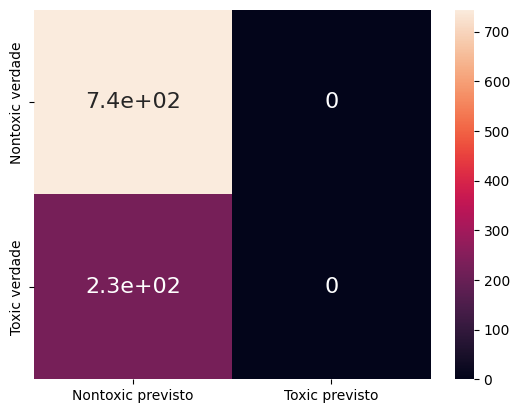

In [404]:
modelo_baseline.fit(X_treino, y_treino)

y_prev_baseline = modelo_baseline.predict(X_teste)
f1_macro_baseline = f1_score(y_verdadeiro, y_prev_baseline, pos_label="Nontoxic")

print(f"O f1_macro do modelo baseline foi: {f1_macro_baseline}")
matriz(y_prev_baseline)

#### **Avaliando K-NN:**

O f1_macro do modelo K-NN foi: 0.9331602855288773
Matriz de Confusão:


<Axes: >

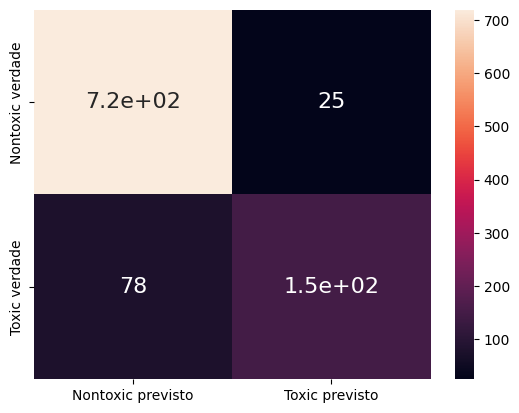

In [405]:
modelo_knn = cria_instancia_knn(melhor_trial_knn)
modelo_knn.fit(X_treino, y_treino)

y_prev_knn = modelo_knn.predict(X_teste)
f1_macro_knn = f1_score(y_verdadeiro, y_prev_knn, pos_label="Nontoxic")

print(f"O f1_macro do modelo K-NN foi: {f1_macro_knn}")
matriz(y_prev_knn)

#### **Avaliando Árvore de Decisão:**

O f1_macro do modelo de Árvore de Decisão foi: 0.9414929388029589
Matriz de Confusão:


<Axes: >

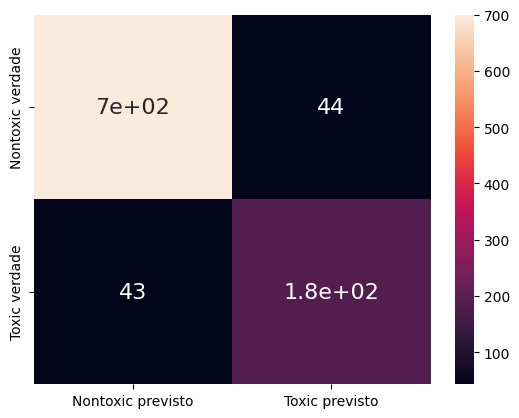

In [406]:
modelo_dtree = cria_instancia_dtree(melhor_trial_dtree)
modelo_dtree.fit(X_treino, y_treino)

y_prev_dtree = modelo_dtree.predict(X_teste)
f1_macro_dtree = f1_score(y_verdadeiro, y_prev_dtree, pos_label="Nontoxic")

print(f"O f1_macro do modelo de Árvore de Decisão foi: {f1_macro_dtree}")
matriz(y_prev_dtree)

#### **Avaliando Floresta Aleatória:**

O f1_macro do modelo de Floresta Aleatória foi: 0.9555997349237906
Matriz de Confusão:


<Axes: >

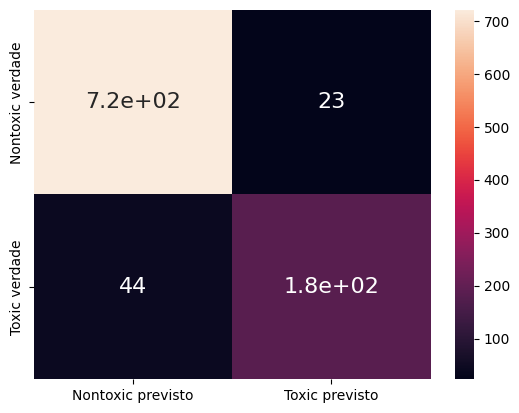

In [407]:
modelo_rf = cria_instancia_rf(melhor_trial_rf)
modelo_rf.fit(X_treino, y_treino)

y_prev_rf = modelo_rf.predict(X_teste)
f1_macro_rf = f1_score(y_verdadeiro, y_prev_rf, pos_label="Nontoxic")

print(f"O f1_macro do modelo de Floresta Aleatória foi: {f1_macro_rf}")
matriz(y_prev_rf)

#### **Avaliando Regressão Logística:**

O f1_macro do modelo de Regressão Logística foi: 0.8544395924308588
Matriz de Confusão:


<Axes: >

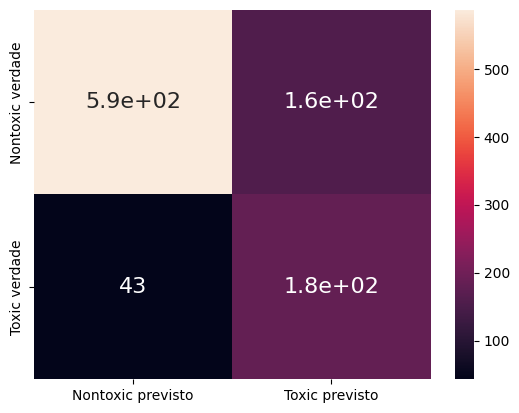

In [408]:
modelo_lr = cria_instancia_lr(melhor_trial_lr)
modelo_lr.fit(X_treino, y_treino)

y_prev_lr = modelo_lr.predict(X_teste)
f1_macro_lr = f1_score(y_verdadeiro, y_prev_lr, pos_label="Nontoxic")

print(f"O f1_macro do modelo de Regressão Logística foi: {f1_macro_lr}")
matriz(y_prev_lr)

#### **Avaliando SVC:**

O f1_macro do modelo SVC foi: 0.9166092350103378
Matriz de Confusão:


<Axes: >

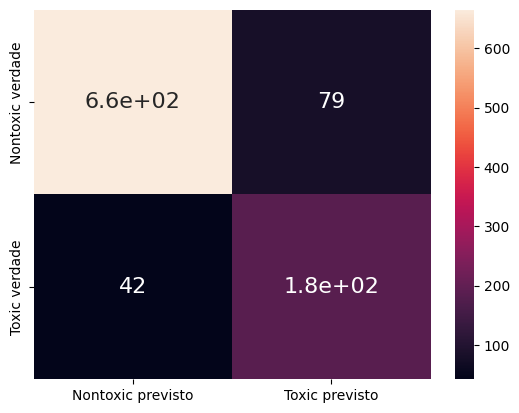

In [409]:
modelo_svc = cria_instancia_svc(melhor_trial_svc)
modelo_svc.fit(X_treino, y_treino)

y_prev_svc = modelo_svc.predict(X_teste)
f1_macro_svc = f1_score(y_verdadeiro, y_prev_svc, pos_label="Nontoxic")

print(f"O f1_macro do modelo SVC foi: {f1_macro_svc}")
matriz(y_prev_svc)

#### **Métricas alternativas**

Não só o f1-macro pode ser usado como métrica de desempenho. Para classificação binária, podem ser feitos cálculos como **acurácia** e **recall score**. Ambas são crescentes com o desempenho do modelo (ou seja, sempre que optar por elas, seu objetivo será *maximizá-las*) e variam de 0 a 1, mas são diferentes.

**Acurácia** é a razão entre a soma dos verdadeiros positivos e dos verdadeiros negativos e o número total de dados. Ou seja, é a *frequência com que a previsão coincide com a realidade*.

In [401]:
def acuracia(y_previsto):
    return accuracy_score(y_verdadeiro, y_previsto)

acuracia_baseline = acuracia(y_prev_baseline)
acuracia_knn = acuracia(y_prev_knn)
acuracia_dtree = acuracia(y_prev_dtree)
acuracia_rf = acuracia(y_prev_rf)
acuracia_lr = acuracia(y_prev_lr)
acuracia_svc = acuracia(y_prev_svc)

print(f"A acurácia do modelo baseline foi: {acuracia_baseline}")
print(f"A acurácia do modelo knn foi: {acuracia_knn}")
print(f"A acurácia do modelo de árvore de decisão foi: {acuracia_dtree}")
print(f"A acurácia do modelo de floresta aleatória foi: {acuracia_rf}")
print(f"A acurácia do modelo de regressão logística foi: {acuracia_lr}")
print(f"A acurácia do modelo SVC foi: {acuracia_svc}")

A acurácia do modelo baseline foi: 0.7670103092783506
A acurácia do modelo knn foi: 0.8938144329896908
A acurácia do modelo de árvore de decisão foi: 0.9103092783505154
A acurácia do modelo de floresta aleatória foi: 0.9309278350515464
A acurácia do modelo de regressão logística foi: 0.7938144329896907
A acurácia do modelo SVC foi: 0.8752577319587629


Já **recall** é a razão entre o número de verdadeiros positivos e a soma dos verdadeiros positivos com os falsos negativos. Ou seja, é a *razão entre os positivos corretamente previstos e todos os dados que são positivos na realidade*. Dessa forma, é uma boa métrica em casos em que é muito importante identificar os positivos (por exemplo, compostos tóxicos).

In [402]:
def recall(y_previsto):
    return recall_score(y_verdadeiro, y_previsto, labels=ordem_labels, pos_label="Nontoxic")

recall_baseline = recall(y_prev_baseline)
recall_knn = recall(y_prev_knn)
recall_dtree = recall(y_prev_dtree)
recall_rf = recall(y_prev_rf)
recall_lr = recall(y_prev_lr)
recall_svc = recall(y_prev_svc)

print(f"O recall score do modelo baseline foi: {recall_baseline}")
print(f"O recall score do modelo knn foi: {recall_knn}")
print(f"O recall score do modelo de árvore de decisão foi: {recall_dtree}")
print(f"O recall score do modelo de floresta aleatória foi: {recall_rf}")
print(f"O recall score do modelo de regressão logística foi: {recall_lr}")
print(f"O recall score do modelo SVC foi: {recall_svc}")

O recall score do modelo baseline foi: 1.0
O recall score do modelo knn foi: 0.9663978494623656
O recall score do modelo de árvore de decisão foi: 0.9408602150537635
O recall score do modelo de floresta aleatória foi: 0.9690860215053764
O recall score do modelo de regressão logística foi: 0.7889784946236559
O recall score do modelo SVC foi: 0.8938172043010753


Repare que o recall do baseline é máximo, igual a 1. Isso ocorre sempre que o valor positivo é a moda dos dados de treino, porque o número de negativos previstos (falsos ou verdadeiros) é zero! O que não quer dizer que o baseline é o melhor modelo: se os negativos fossem a moda, o número de positivos previstos seria zero, e o recall também. Por isso, a escolha da métrica deve ser adequada ao modelo e ao conjunto de dados - lembre que ela é importante para a otimização de hiperparâmetros, na qual usou-se apenas o f1-macro.

Observe a comparação entre os desempenhos estimados por validação cruzada e medidos com diferentes métricas:

### **Conclusão**

Neste notebook, implementamos e otimizamos diversos modelos de aprendizado de máquina para prever a toxicidade de nanopartículas com base em suas características físico-químicas e condições experimentais. Utilizamos técnicas como agrupamento de dados para evitar vazamento, codificação one-hot para variáveis categóricas e validação cruzada para garantir a qualidade das métricas.

Assim, após determinarmos o ``TARGET`` e as ``FEATRUES``, escrevemos a função objetivo para otimizar os hiperparâmetros de cada modelo de aprendizado. A métrica de interesse calculada foi a `f1_macro` e também calculamos de forma auxiliar a ``acurácia`` e o ``recall_score`` . A **floresta aleatória** foi o algoritmo de aprendizado de máquina que performou melhor segundo as métricas alvo calculadas, pontuando 0.9555 em F1-Macro nos dados de teste, 0.9690 de _recall_score_ e 0.9309 de _acurácia_. 

Os dempenhos podem ser melhores observados nessa tabela:

| Modelo               |  Estimativa F1-Macro (``y_treino``) | F1-Macro (``y_teste``) | Recall | Acurácia |
|----------------------|-------------------------------------|------------------------|--------|----------|
| Baseline             |                              0.8681 |                 0.8681 | 1.0000 |   0.7670 |
| K-NN                 |                              0.8402 |                 0.9331 | 0.9663 |   0.8938 |
| Árvore de Decisão    |                              0.8961 |                 0.9414 | 0.9408 |   0.9103 |
| Floresta Aleatória   |                              0.9112 |                 0.9555 | 0.9690 |   0.9309 |
| Regressão Logística  |                              0.7383 |                 0.8544 | 0.7889 |   0.7938 |
| SVC                  |                              0.8508 |                 0.9166 | 0.8938 |   0.8752 |

De forma geral os modelos obtiveram um desempenho melhor que o baseline, exceto pela regressão logística, porvavelmente os dados de nanotoxicologia utlizados envolvem relações complexas e não lineares entre as características dos materiais e sua toxicidade, que modelos como Floresta Aleatória e Árvore de Decisão conseguem capturar melhor.

### **Perspectivas**

No futuro, esse trabalho pode ser mais desenvolvido pela: coleta de mais dados experimentais de diferentes estudos, a aplicação de modelos de aprendizado mais avançados (``XGBoost``, ``LightGBM``, ``CatBoost``), análise de importância de features usando o SHAP ou LIME, por exemplo. 

### **Referências**

CASSAR, Daniel Roberto. Classificação binária. [Jupyter Notebook], Ilum – Escola de Ciência, Campinas, 2025.

CASSAR, Daniel Roberto. Otimização de hiperparâmetros com optuna. [Jupyter Notebook], Ilum – Escola de Ciência, Campinas, 2025.

CASSAR, Daniel Roberto. Validação cruzada e otimização de hiperparâmetros. [Jupyter Notebook], Ilum – Escola de Ciência, Campinas, 2025.

NUMPY DEVELOPERS. NumPy documentation. Disponível em: https://numpy.org/doc/ . Acesso em: 1 nov. 2025.

OPTUNA DEVELOPERS. Optuna documentation. Disponível em: https://optuna.org/ . Acesso em: 1 nov. 2025.

PANDAS DEVELOPMENT TEAM. pandas documentation. Disponível em: https://pandas.pydata.org/docs/ . Acesso em: 1 nov. 2025.

SCIKIT-LEARN DEVELOPERS. Scikit-learn documentation. Disponível em: https://scikit-learn.org/stable/ . Acesso em: 1 nov. 2025.

SCIPY DEVELOPERS. SciPy documentation. Disponível em: https://docs.scipy.org/doc/ . Acesso em: 1 nov. 2025.

WASKOM, Michael et al. Seaborn documentation. Disponível em: https://seaborn.pydata.org/ . Acesso em: 1 nov. 2025.